Code Reference: https://github.com/abdur75648/Deep-Learning-Specialization-Coursera/blob/main/Neural%20Networks%20and%20Deep%20Learning/Week2/Logistic%20Regression%20as%20a%20Neural%20Network/Logistic_Regression_with_a_Neural_Network_mindset_v6a.ipynb

# CLASSIFICATION PROBLEM: Logistic Regression with a Neural Network 

Reference: Neural Networks and Deep Learning, coursera.  
You will build a logistic regression classifier to recognize cats. 

**Instructions:**
- We avoid loops and use `np.dot(X,Y)` to calculate dot products.

**You will learn to:**
- Build the general architecture of a learning algorithm, including:
    - Initializing parameters
    - Calculating the cost function and its gradient
    - Using an optimization algorithm (gradient descent) 
- Gather all three functions above into a main model function, in the right order.

In [2]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import h5py
import scipy
#from PIL import Image
from scipy import ndimage


<a name='2'></a>
## 2 - Overview of the Problem set ##

**Problem Statement**: You are given a dataset ("data.h5") containing:
    - a training set of m_train images labeled as cat (y=1) or non-cat (y=0)
    - a test set of m_test images labeled as cat or non-cat
    - each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB). Thus, each image is square (height = num_px) and (width = num_px).

You will build a simple image-recognition algorithm that can correctly classify pictures as cat or non-cat.

Let's get more familiar with the dataset. Load the data by running the following code.

In [3]:
def load_dataset():
    train_dataset = h5py.File('train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [4]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

We added "_orig" at the end of image datasets (train and test) because we are going to preprocess them. After preprocessing, we will end up with train_set_x and test_set_x (the labels train_set_y and test_set_y don't need any preprocessing).

Each line of your train_set_x_orig and test_set_x_orig is an array representing an image. You can visualize an example by running the following code. Feel free also to change the `index` value and re-run to see other images. 

y = [1], it's a 'cat' picture.


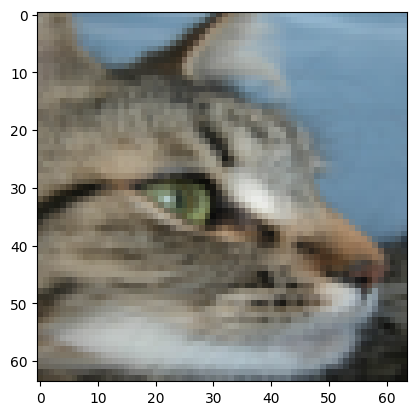

In [7]:
# Example of a picture
index = 68
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

Many software bugs in deep learning come from having matrix/vector dimensions that don't fit. If you can keep your matrix/vector dimensions straight you will go a long way toward eliminating many bugs. 

<a name='ex-1'></a>
### Exercise 1
Find the values for:
    - m_train (number of training examples)
    - m_test (number of test examples)
    - num_px (= height = width of a training image)
Remember that `train_set_x_orig` is a numpy-array of shape (m_train, num_px, num_px, 3). For instance, you can access `m_train` by writing `train_set_x_orig.shape[0]`.

In [8]:
m_train = train_set_x_orig.shape[0] 
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[2] 

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


**Expected Output for m_train, m_test and num_px**: 
<table style="width:15%">
  <tr>
    <td> m_train </td>
    <td> 209 </td> 
  </tr>
  
  <tr>
    <td>m_test</td>
    <td> 50 </td> 
  </tr>
  
  <tr>
    <td>num_px</td>
    <td> 64 </td> 
  </tr>
  
</table>


For convenience, you should now reshape images of shape (num_px, num_px, 3) in a numpy-array of shape (num_px $*$ num_px $*$ 3, 1). After this, our training (and test) dataset is a numpy-array where each column represents a flattened image. There should be m_train (respectively m_test) columns.

<a name='ex-2'></a>
### Exercise 2
Reshape the training and test data sets so that images of size (num_px, num_px, 3) are flattened into single vectors of shape (num\_px $*$ num\_px $*$ 3, 1).

A trick when you want to flatten a matrix X of shape (a,b,c,d) to a matrix X_flatten of shape (b$*$c$*$d, a) is to use: 
```python
X_flatten = X.reshape(X.shape[0], -1).T      # X.T is the transpose of X
```

In [9]:
# Reshape the training and test examples

#train_set_x_flatten = train_set_x_orig.reshape(64*64*3,1)
#test_set_x_flatten = test_set_x_orig.reshape(64*64*3,1)

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0],-1).T

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)


**Expected Output**: 

<table style="width:35%">
  <tr>
    <td>train_set_x_flatten shape</td>
    <td> (12288, 209)</td> 
  </tr>
  <tr>
    <td>train_set_y shape</td>
    <td>(1, 209)</td> 
  </tr>
  <tr>
    <td>test_set_x_flatten shape</td>
    <td>(12288, 50)</td> 
  </tr>
  <tr>
    <td>test_set_y shape</td>
    <td>(1, 50)</td> 
  </tr>
</table>

To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from 0 to 255.

One common preprocessing step in ML is to center and standardize your dataset, meaning that you substract the mean of the whole numpy array from each example, and then divide each example by the standard deviation of the whole numpy array. But for picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

<!-- During the training of your model, you're going to multiply weights and add biases to some initial inputs in order to observe neuron activations. Then you backpropogate with the gradients to train the model. But, it is extremely important for each feature to have a similar range such that our gradients don't explode. You will see that more in detail later in the lectures. !--> 

Let's standardize our dataset.

In [10]:
train_set_x = train_set_x_flatten / 255.
test_set_x = test_set_x_flatten / 255.

<font color='blue'>
    
    
**What you need to remember:**

Common steps for pre-processing a new dataset are:
- Figure out the dimensions and shapes of the problem (m_train, m_test, num_px, ...)
- Reshape the datasets such that each example is now a vector of size (num_px \* num_px \* 3, 1)
- "Standardize" the data

<a name='3'></a>
## 3 - General Architecture of the learning algorithm ##


**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

**Key steps**:
In this exercise, you will carry out the following steps: 
    - Initialize the parameters of the model
    - Learn the parameters for the model by minimizing the cost  
    - Use the learned parameters to make predictions (on the test set)
    - Analyse the results and conclude

In [ ]:
def sigmoid(z):
    s = 1/(1+np.exp(-z))
    return s

In [ ]:
def initialize_with_zeros(dim):
    w = np.zeros((dim, 1))
    b = 0.0

    return w, b

In [ ]:
def propagate(w, b, X, Y):
        
    m = X.shape[1]
    
    # FORWARD PROPAGATION FROM X TO COST)
    # compute activation
    A = sigmoid(np.dot(w.T,X)+ b)
    # compute cost by using np.dot to perform multiplication. And don't use loops for the sum.
    cost = -(1/m)*(np.dot(Y,np.log(A).T) +  np.dot(1-Y,np.log(1-A).T))   

    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = (1/m)*(np.dot(X,(A-Y).T))
    db = (1/m)*(np.sum(A)-np.sum(Y))

    cost = np.squeeze(np.array(cost))

    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [ ]:
def optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False):
     
    w = copy.deepcopy(w)
    b = copy.deepcopy(b)
    
    costs = []
    
    for i in range(num_iterations):
        
        # Cost and gradient calculation 
        grads, cost = propagate(w, b, X, Y)
                
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule 
        w = w - learning_rate*dw
        b = b - learning_rate*db
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
            # Print the cost every 100 training iterations
            if print_cost:
                print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [ ]:
# For the Classification problem

def predict(w, b, X):
    
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture

    A = sigmoid(np.dot(w.T,X)+ b)
    
    for i in range(A.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if A[0, i] > 0.5 :
             Y_prediction[0,i] = 1 
        else:
             Y_prediction[0,i] = 0

    return Y_prediction

In [ ]:
def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):

    # initialize parameters with zeros 
    w, b = initialize_with_zeros(X_train.shape[0])
    
    # Gradient descent 
    params, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "params"
    w = params["w"]
    b = params["b"]
    print(w,b)

    # Predict test/train set examples 
    Y_prediction_train = predict(w, b, X_train)
    Y_prediction_test = predict(w, b, X_test)
    
    # Print train/test Errors
    if print_cost:
        print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
        print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
   
    return d

In [ ]:
logistic_regression_model = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=2000, learning_rate=0.005, print_cost=True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
[[ 0.00961402]
 [-0.0264683 ]
 [-0.01226513]
 ...
 [-0.01144453]
 [-0.02944783]
 [ 0.02378106]] -0.015906243999692985
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


y = 1, you predicted that it is a "cat" picture.


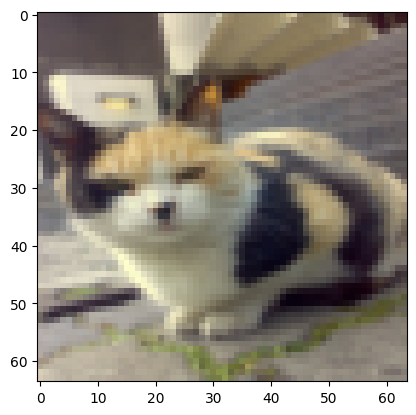

In [ ]:
# Example of a picture that was wrongly classified.
index = 42
plt.imshow(test_set_x[:, index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + classes[int(logistic_regression_model['Y_prediction_test'][0,index])].decode("utf-8") +  "\" picture.")

In [ ]:
# Example of a picture that was wrongly classified.
for index in range(50):
  print ("index = " + str(index) +", y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + classes[int(logistic_regression_model['Y_prediction_test'][0,index])].decode("utf-8") +  "\" picture.")

index = 0, y = 1, you predicted that it is a "cat" picture.
index = 1, y = 1, you predicted that it is a "cat" picture.
index = 2, y = 1, you predicted that it is a "cat" picture.
index = 3, y = 1, you predicted that it is a "cat" picture.
index = 4, y = 1, you predicted that it is a "cat" picture.
index = 5, y = 0, you predicted that it is a "cat" picture.
index = 6, y = 1, you predicted that it is a "non-cat" picture.
index = 7, y = 1, you predicted that it is a "cat" picture.
index = 8, y = 1, you predicted that it is a "cat" picture.
index = 9, y = 1, you predicted that it is a "cat" picture.
index = 10, y = 1, you predicted that it is a "non-cat" picture.
index = 11, y = 1, you predicted that it is a "non-cat" picture.
index = 12, y = 1, you predicted that it is a "cat" picture.
index = 13, y = 0, you predicted that it is a "cat" picture.
index = 14, y = 0, you predicted that it is a "non-cat" picture.
index = 15, y = 1, you predicted that it is a "cat" picture.
index = 16, y = 0,

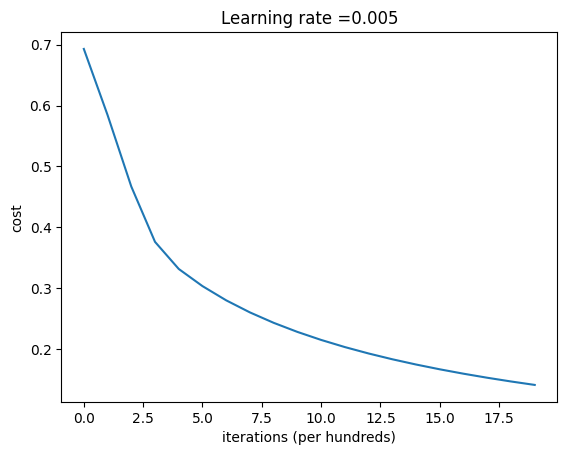

In [ ]:
# Plot learning curve (with costs)
costs = np.squeeze(logistic_regression_model['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(logistic_regression_model["learning_rate"]))
plt.show()

Training a model with learning rate: 0.01
[[ 0.01280149]
 [-0.03466593]
 [-0.01552747]
 ...
 [-0.01481023]
 [-0.03723668]
 [ 0.03117718]] -0.0038534044207178147

-------------------------------------------------------

Training a model with learning rate: 0.001
[[ 0.00388218]
 [-0.00802229]
 [-0.00375977]
 ...
 [-0.0042936 ]
 [-0.01110565]
 [ 0.00659217]] -0.01101601341986631

-------------------------------------------------------

Training a model with learning rate: 0.0001
[[ 0.00090564]
 [-0.00099018]
 [-0.00014868]
 ...
 [-0.00051939]
 [-0.00179446]
 [ 0.00090753]] -0.002325483107934361

-------------------------------------------------------



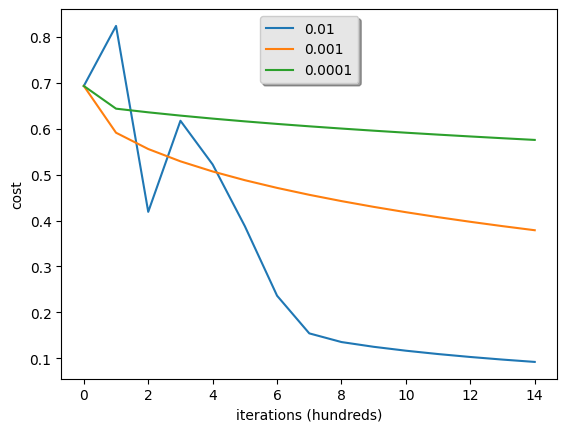

In [ ]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}

for lr in learning_rates:
    print ("Training a model with learning rate: " + str(lr))
    models[str(lr)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=1500, learning_rate=lr, print_cost=False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for lr in learning_rates:
    plt.plot(np.squeeze(models[str(lr)]["costs"]), label=str(models[str(lr)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()